In [ ]:
%%capture
!pip install jiwer

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


In [ ]:
print("Versi Pandas:", pd.__version__)
print("Versi NumPy:", np.__version__)
print("Versi TensorFlow:", tf.__version__)
print("Versi Keras:", keras.__version__)
print("Versi Jiwer:", wer.__version__)


Versi Pandas: 1.5.3
Versi NumPy: 1.23.5
Versi TensorFlow: 2.13.0


AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metadata_path="/content/drive/MyDrive/Audio_Dataset/metadata_asr.csv"
metadata_df = pd.read_csv(metadata_path, sep=",", header=None, quoting=3)
metadata_df.columns = ["path", "file_name", "sentence"]
metadata_df = metadata_df[["path","file_name", "sentence"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(5)

,path,file_name,sentence
0,/content/drive/MyDrive/Audio_Dataset/mono_outp...,080032_19.wav,مَتَاعًا لَكُمْ وَلِأَنْعَامِكُمْ
1,/content/drive/MyDrive/Audio_Dataset/mono_outp...,082016_04.wav,وَمَا هُمْ عَنْهَا بِغَائِبِينَ
2,/content/drive/MyDrive/Audio_Dataset/mono_outp...,089009_24.wav,وَثَمُودَ الَّذِينَ جَابُوا الصَّخْرَ بِالْوَادِ
3,/content/drive/MyDrive/Audio_Dataset/mono_outp...,100003_03.wav,فَالْمُغِيرَاتِ صُبْحًا
4,/content/drive/MyDrive/Audio_Dataset/mono_outp...,086004_17.wav,إِنْ كُلُّ نَفْسٍ لَمَّا عَلَيْهَا حَافِظٌ


In [ ]:
split = int(len(metadata_df) * 0.8)
split1 = int(len(metadata_df) * 0.10)
df_train = metadata_df[:split]
df_val = metadata_df[split:split+split1]
df_test = metadata_df[split+split1:]
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validating set: {len(df_val)}")
print(f"Size of the testing set: {len(df_test)}")

Size of the training set: 12647
Size of the validating set: 1580
Size of the testing set: 1582


In [ ]:
wavs_path='/content/drive/MyDrive/Audio_Dataset/mono_output/'

In [ ]:
print(wavs_path)

/content/drive/MyDrive/Audio_Dataset/mono_output/


In [ ]:
# The set of characters accepted in the transcription.
from tensorflow import keras

characters = [
    x for x in "ْابتثجحخةدذرزسشصضطظعغفقكلمنهويءآأؤإئىًٌٍَُِّ "
]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'ْ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'ة', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ى', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', ' '] (size =46)


In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path+wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
batch_train=8
batch_val=8
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample)
    .padded_batch(batch_train)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample)
    .padded_batch(batch_val)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

Text :  مَتَاعًا لَكُمْ وَلِأَنْعَامِكُمْ
/content/drive/MyDrive/Audio_Dataset/mono_output/080032_19.wav


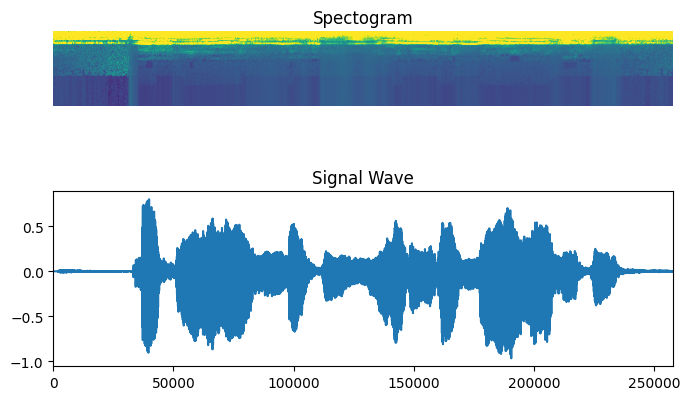

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title("Spectogram")
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path+list(df_train["file_name"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
    print("Text : ", label)
    print(wavs_path+list(df_train["file_name"])[0])
plt.show()

In [ ]:
print(list(df_train["sentence"])[0])

مَتَاعًا لَكُمْ وَلِأَنْعَامِكُمْ


In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)



```
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint("/content/drive/MyDrive/Audio_Dataset/model_checkpoint/model_dual.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register the custom loss function
get_custom_objects().update({'CTCLoss': CTCLoss})

# Load the model
model = load_model('/content/drive/MyDrive/Audio_Dataset/model_checkpoint/model_checkpoint_new.h5')


In [ ]:
model.save('/content/drive/MyDrive/Audio_Dataset/model_checkpoint/my_model.keras')

In [ ]:
# Define the number of epochs.
epochs = 10
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback,checkpoint_callback],
)

Epoch 1/10
  81/1581 [>.............................] - ETA: 2:30:09 - loss: 17.3802

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 50):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 1s 981ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1963
----------------------------------------------------------------------------------------------------
Target    : لَيْسَ لَهُمْ طَعَامٌ إِلَّا مِنْ ضَرِيعٍ
Prediction: لَيْسَ لَهُمْ طَعَامٌ إِلَّا مِنْضَرِيمم
----------------------------------------------------------------------------------------------------
Target    : فَأَمَّا مَنْ طَغَى
Prediction: فَأَمَّا مَا طَغَى
----------------------------------------------------------------------------------------------------
Target    : جَزَاءً مِنْ رَبِّكَ عَطَاءً حِسَابًا
Prediction: فَجَفَاءً  مِنْ رَبِّكَ عَطَاءً حِسَابًا
----------------------------------------------------------------------------------------------------
Target    : وَقَدْ خَابَ مَنْ دَسَّاهَا
Prediction: وَقَدْ خَابَ مَنْ دَسَّاهَا
-----------------------------------------------------------------

In [ ]:
import csv

# Path to the input CSV file
input_csv_file = '/content/drive/MyDrive/Audio_Dataset/metadata_fix_drive.csv'

# Path to the output CSV file
output_csv_file = '/content/drive/MyDrive/Audio_Dataset/metadata_monoaudio.csv'

import pandas as pd


# Load the CSV into a DataFrame
data = pd.read_csv(input_csv_file)

# Function to modify the directory path
def modify_directory_path(directory_path):
    parts = directory_path.split('/')
    parts[-2] = 'mono_output'
    modified_path = '/'.join(parts)
    return modified_path

# Modify the "path" column
data['path'] = data['path'].apply(modify_directory_path)

# Save the modified DataFrame to a new CSV file
data.to_csv(output_csv_file, index=False)

print("CSV file paths have been modified and saved.")

In [ ]:
import csv

# Open the input CSV file
with open('/content/drive/MyDrive/Audio_Dataset/metadata_fix_drive.csv', 'r', newline='', encoding='utf-8') as input_file:
    csv_reader = csv.DictReader(input_file)
    rows = list(csv_reader)  # Read all rows into a list

# Create a new list to store modified rows
modified_rows = []

# Loop through each row and modify the directory path
for row in rows:
    old_path = row['path']
    filename = old_path.split('/')[-1]  # Extract the filename from the path
    new_path = "/content/drive/MyDrive/Audio_Dataset/mono_output/" + filename
    modified_rows.append({
        'path': new_path,
        'file_name': row['file_name'],
        'sentence': row['sentence']
    })

# Write the modified rows to a new CSV file
fieldnames = ['path', 'file_name', 'sentence']
with open('/content/drive/MyDrive/Audio_Dataset/metadata_monoaudio.csv', 'w', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(modified_rows)


In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
import os

input_folder = "/content/drive/MyDrive/Audio_Dataset/audio_folder"
output_folder = "/content/drive/MyDrive/Audio_Dataset/mono_output"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Load the audio
        sound = AudioSegment.from_wav(input_path)

        # Convert to mono
        sound = sound.set_channels(1)

        # Export the mono audio
        sound.export(output_path, format="wav")

print("Conversion to mono completed for all audio files.")

In [ ]:
import shutil
import os

source_folder = '/content/drive/MyDrive/Audio_Dataset/Reciters'
destination_folder = '/content/drive/MyDrive/Audio_Dataset/audio_folder'

for root, dirs, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.wav'):
            source_path = os.path.join(root, file)
            shutil.move(source_path, destination_folder)
